## This is my attempt at implementing the RouBl algorithm

In [67]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=[0.1,0.1], alpha=0.1, gamma=1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n

        # define the prior parameters
        # prior_mean = torch.randn(n, **factory_kwargs) * prior_std[0]
        prior_mean = torch.zeros(n)
        # prior_cov_chol =  torch.eye(n, **factory_kwargs) * prior_std[1] + torch.tril(torch.randn(n,n) * prior_std[1], diagonal=-1)
        prior_cov_chol = torch.eye(n, **factory_kwargs) * prior_std[1]

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', prior_mean)
        self.register_buffer('prior_cov_chol', prior_cov_chol)
        self.register_buffer('prior_cov_inv', torch.linalg.inv(prior_cov_chol @ prior_cov_chol.t()))

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = prior_mean
        self.cov_chol = prior_cov_chol
        # self.cov_chol = torch.diag(prior_std*torch.ones(n, **factory_kwargs))

        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean

    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    # @property
    # def scale_tril(self):
    #     # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
    #     # Only taking values below the main diagonal? no it takes everything below diagonal
    #     return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_std=[0.1, 0.1])
input_data = torch.tensor(([1.0], [1.5]), requires_grad=False)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)


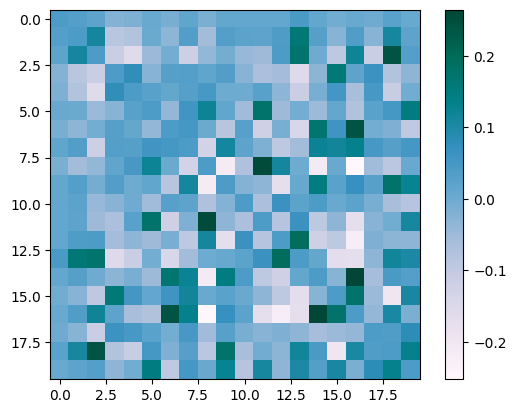

In [6]:
factory_kwargs = {'device': None, 'dtype': None}
n = 20
prior_std=[0.1, 0.2]

prior_mean = torch.randn(n, **factory_kwargs) * prior_std[0]
prior_cov_chol =  torch.tril(torch.randn(n,n) * prior_std[1])

# print(prior_cov_chol)
# print((prior_cov_chol @ prior_cov_chol.t()))

prior_cov = prior_cov_chol @ prior_cov_chol.t()
for i in range(n):
    prior_cov[i,i] = prior_std[1]**2

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

a = to_numpy(prior_cov)

plt.imshow(a, cmap='PuBuGn')
plt.colorbar()
plt.show()

In [188]:
factory_kwargs = {'device': None, 'dtype': None}
n = 5
prior_std=[0.1, 0.2]

torch.eye(n, **factory_kwargs) * prior_std[1]

tensor([[0.2000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000]])

In [189]:
A = torch.randn(n, n) * prior_std[1]
M = (A + A.T) / 2  # Symmetric
M += n * torch.eye(n)  # Positive definite



### Regression Ground Truth & Dataset

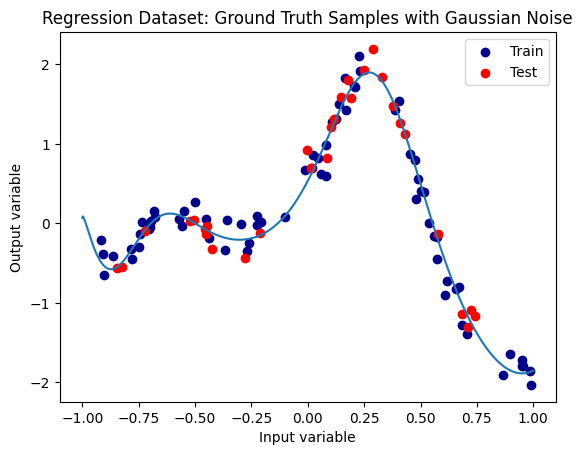

In [161]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Plot BNN Prior in Function Space

In [4]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.2,0.3], alpha=1, gamma=0.0001)

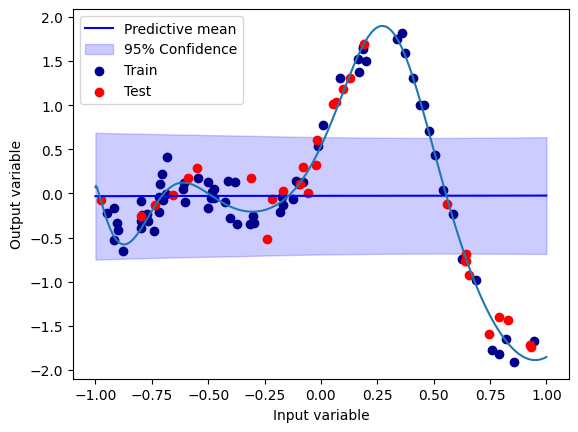

In [8]:
def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

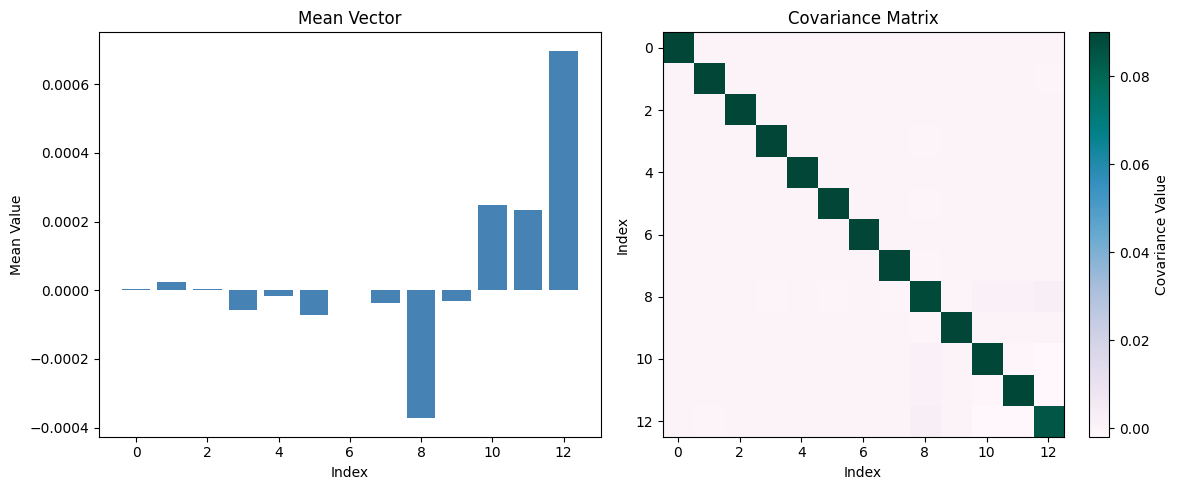

In [12]:
def plot_mean_and_covariance(BNN):
    # Convert mean vector and covariance matrix to NumPy
    mean = to_numpy(BNN.mean)
    cov = to_numpy(BNN.cov_chol @ BNN.cov_chol.t())

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot mean vector as a bar plot
    axs[0].bar(range(len(mean)), mean, color='steelblue')
    axs[0].set_title("Mean Vector")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Mean Value")

    # Plot covariance matrix as a heatmap
    im = axs[1].imshow(cov, cmap='PuBuGn', aspect='auto')
    axs[1].set_title("Covariance Matrix")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Index")
    fig.colorbar(im, ax=axs[1], label="Covariance Value")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_mean_and_covariance(BNN)


### Training

In [9]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=[0.2,0.3], alpha=0.0001, gamma=1)

In [10]:
def compute_param_gradients(net, input, targets, noise, K=500):
    gradients = torch.zeros(net.num_params, requires_grad=False)
    for _ in range(K):
        sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
        print('Params', sampled_params)
        if sampled_params.grad is not None:
            sampled_params.grad.zero_()
        output = net.forward(input, sampled_params)  # Forward pass
        print('output:',output)
        for i in range(output.shape[0]):
            output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True)  # Backpropagate to calculate gradients

        net_grads = sampled_params.grad
        g_k = net.gamma * net.prior_cov_inv @ (sampled_params - net.prior_mean) + net_grads
        gradients += g_k

    # print(f'Max gradient is {torch.max(1/K * gradients.unsqueeze(1))}')
    # print('grads',(1/K * gradients.unsqueeze(1)))
    return 1/K * gradients.unsqueeze(1)


# BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=0.1, init_std=0.1, alpha=0.01, gamma=1)
# input_data = torch.tensor(([1.0], [1.5]), requires_grad=True)
# targets = torch.tensor(([2.0], [2.1]), requires_grad=False)

Epoch 1
Params tensor([-0.3836, -0.0715, -0.3760, -0.0295,  0.0581, -0.3306,  0.0744, -0.2308,
        -0.3798, -0.3073,  0.0674,  0.1265,  0.3745], requires_grad=True)
output: tensor([[0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.3738],
        [0.37

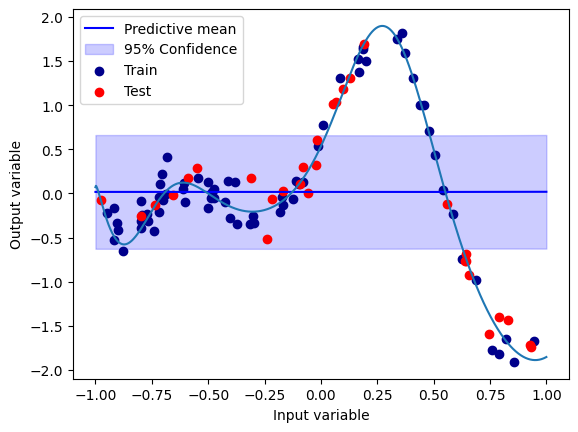

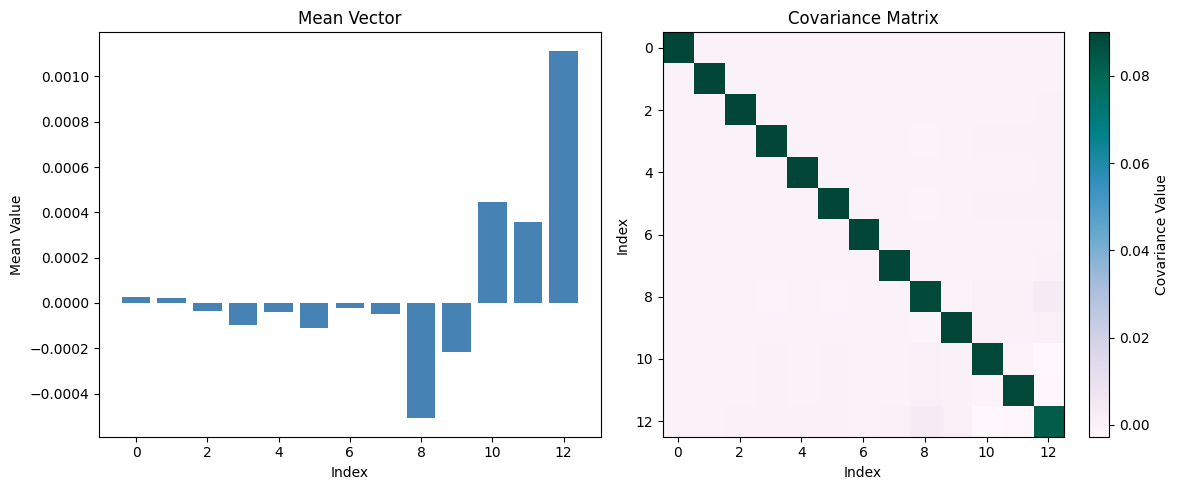

In [13]:
# Using sigma (not its chol), runs into errors computing chol at the end
def update_variational_params(net, input, targets, noise=0.1, K=500):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    g_tp = g.t()

    with torch.no_grad():
        mu, sigma = net.mean.unsqueeze(1), net.cov_chol @ net.cov_chol.t()
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        
        sigma_tilde = 1 / (1 - alpha*gamma) * sigma
        v = sigma_tilde @ g 
        sigma = sigma_tilde - alpha / (1 + alpha * g_tp @ v) * v @ v.t()
        nu = g_tp @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha * (1 - nu) * g

    net.lambda_1 = lambda_1.flatten()
    net.mean = (sigma @ lambda_1).flatten()
    net.cov_chol = torch.linalg.cholesky(sigma, upper=False)


# Using rank-1 cholesky update algo
def update_variational_params2(net, input, targets, noise, K=100):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        
        v = alpha_prime * chol @ (chol.t() @ g)

        beta = - alpha / (1 + alpha * g.t() @ v)
        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(alpha_prime * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = alpha_prime * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(alpha_prime) * chol[k,j]
                chol_new[k,j] = torch.sqrt(alpha_prime) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(alpha_prime * chol[j,j]**2)

        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
        
    net.lambda_1 = lambda_1.flatten()
    net.mean = ((chol_new @ chol_new.t())@lambda_1).flatten()
    net.cov_chol = chol_new


# BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.1,0.7], alpha=1, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 1
noise = 0.2

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params(BNN, x_tr, y_tr, noise, K=100)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

plot_mean_and_covariance(BNN)

    


In [144]:
def update_variational_params_choldate(net, input, targets, noise=1, K=100):
    g = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    g_tp = g.t()

    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)

        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        v = alpha_prime * chol @ (chol.t() @ g) #sigma_tilde @ g

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
        
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [net.num_params])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = lambda_1.flatten()
    net.mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
    # print(net.mean)
    net.cov_chol = chol_updated # same here


In [23]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=[0.2,0.3], alpha=0.01, gamma=1)

Epoch 1
Params tensor([ 0.1752,  0.2427,  0.2635,  0.1420,  0.0929, -0.3037,  0.1889,  0.0249,
        -0.0564,  0.0597, -0.1909, -0.2933,  0.0586], requires_grad=True)
output: tensor([[0.0215],
        [0.0235],
        [0.0201],
        [0.0298],
        [0.0257],
        [0.0267],
        [0.0189],
        [0.0198],
        [0.0355],
        [0.0313],
        [0.0292],
        [0.0166],
        [0.0218],
        [0.0324],
        [0.0234],
        [0.0325],
        [0.0355],
        [0.0343],
        [0.0343],
        [0.0265],
        [0.0313],
        [0.0310],
        [0.0233],
        [0.0209],
        [0.0358],
        [0.0178],
        [0.0334],
        [0.0301],
        [0.0246],
        [0.0332],
        [0.0185],
        [0.0318],
        [0.0275],
        [0.0270],
        [0.0237],
        [0.0353],
        [0.0237],
        [0.0290],
        [0.0290],
        [0.0353],
        [0.0340],
        [0.0275],
        [0.0351],
        [0.0268],
        [0.0310],
        [0.03

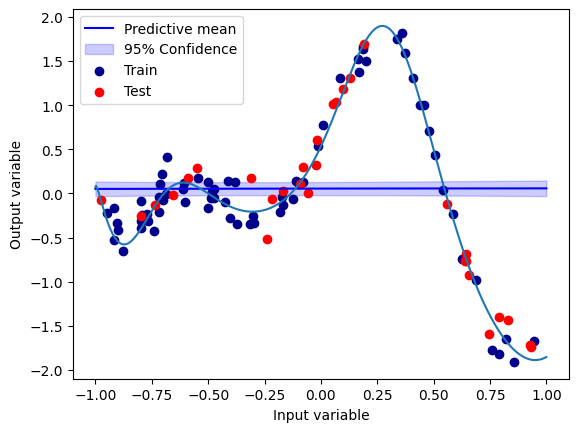

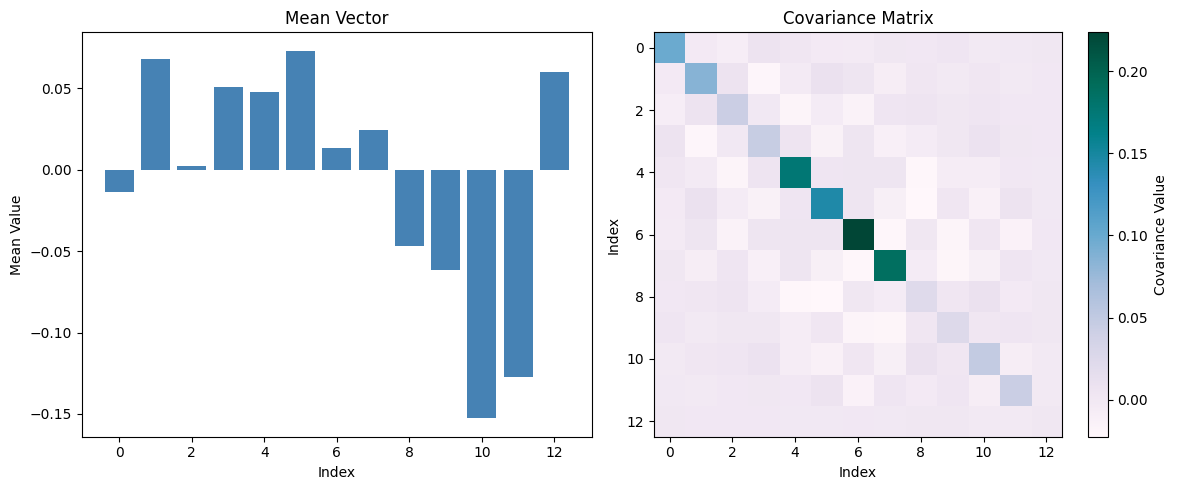

In [20]:

# BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.1,0.7], alpha=1, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 100
noise = 0.2

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, noise, K=10)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

plot_mean_and_covariance(BNN)

    


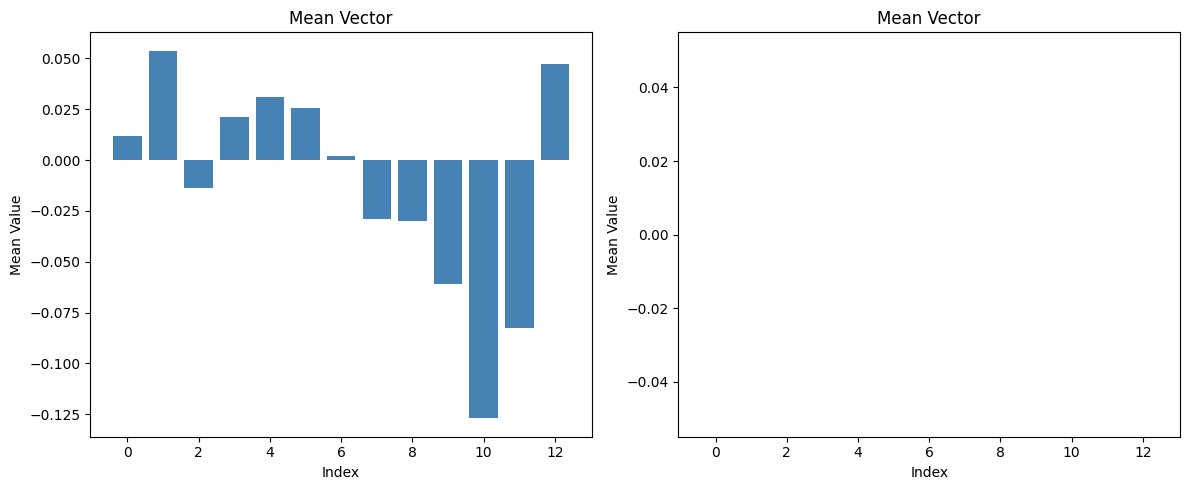

In [18]:
# Convert mean vector and covariance matrix to NumPy
mean = to_numpy(BNN.mean)
prior = to_numpy(BNN.prior_mean)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean vector as a bar plot
axs[0].bar(range(len(mean)), mean, color='steelblue')
axs[0].set_title("Mean Vector")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Mean Value")

# Plot mean vector as a bar plot
axs[1].bar(range(len(prior)), prior, color='steelblue')
axs[1].set_title("Mean Vector")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Mean Value")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [21]:
input_data = torch.tensor(([1.0]), requires_grad=False)
targets = torch.tensor(([2.0]), requires_grad=False)

In [22]:
compute_param_gradients(BNN, input_data, targets, noise = 0.15, K=1)

Params tensor([ 0.0167,  0.0233, -0.3532,  0.1513, -0.3864, -0.1439,  0.5378, -0.0913,
         0.1664,  0.0025, -0.1333,  0.1271,  0.0475], requires_grad=True)
output: tensor([0.0285], grad_fn=<ViewBackward0>)


tensor([[ 1.4007e-01],
        [-1.4123e+00],
        [-3.9702e+00],
        [ 1.0770e-02],
        [-4.3322e+00],
        [ 4.4119e-01],
        [ 5.9756e+00],
        [-1.0342e+00],
        [ 1.3532e+01],
        [-8.3768e-02],
        [-1.3976e+01],
        [ 1.4261e+00],
        [-8.7096e+01]], grad_fn=<MulBackward0>)

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameters (13 in total)
params = torch.tensor([ 0.0232,  0.1553, -0.1484, -0.2393,  0.0467, -0.0928,  0.0435, -0.1294,
        -0.3435,  0.2387,  0.2884,  0.0913,  0.4074])

# Neural Network Structure
class CustomNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_weight = nn.Parameter(params[0:2].view(2, 1))  # 2 weights (2x1 matrix)
        self.fc1_bias = nn.Parameter(params[2:4].view(2))       # 2 biases (vector)
        self.fc2_weight = nn.Parameter(params[4:8].view(2, 2))  # 4 weights (2x2 matrix)
        self.fc2_bias = nn.Parameter(params[8:10].view(2))      # 2 biases (vector)
        self.fc3_weight = nn.Parameter(params[10:12].view(1, 2))  # 2 weights (1x2 matrix)
        self.fc3_bias = nn.Parameter(params[12:13].view(1))       # 1 bias (scalar)

    def forward(self, x):
        # First Layer: Leaky ReLU activation
        x = F.linear(x, self.fc1_weight, self.fc1_bias)
        x = F.leaky_relu(x)
        
        # Second Layer: Leaky ReLU activation
        x = F.linear(x, self.fc2_weight, self.fc2_bias)
        x = F.leaky_relu(x)
        
        # Third Layer: Leaky ReLU activation
        x = F.linear(x, self.fc3_weight, self.fc3_bias)
        x = F.leaky_relu(x)
        
        return x

# Initialize and test
model = CustomNN()
# for i in input_data:
#     output = model(i)
#     output.backward() 
    
output = model(input_data)
print("Output:", output)


Output: tensor([0.4282], grad_fn=<LeakyReluBackward0>)


In [204]:
# Forward pass
output = model(input_data)
params = params.unsqueeze(1)

# Backward pass to compute gradients
output.backward()

# Print gradients of model parameters
print("Gradients:")
print("fc1_weight:", model.fc1_weight.grad)
print("fc1_bias:", model.fc1_bias.grad)
print("fc2_weight:", model.fc2_weight.grad)
print("fc2_bias:", model.fc2_bias.grad)
print("fc3_weight:", model.fc3_weight.grad)
print("fc3_bias:", model.fc3_bias.grad)


Gradients:
fc1_weight: tensor([[ 4.1062e-05],
        [-1.2082e-04]])
fc1_bias: tensor([ 4.1062e-05, -1.2082e-04])
fc2_weight: tensor([[-3.6108e-06, -2.4226e-06],
        [-1.1431e-04, -7.6692e-05]])
fc2_bias: tensor([0.0029, 0.0913])
fc3_weight: tensor([[-0.0034,  0.2388]])
fc3_bias: tensor([1.])


In [205]:
df_dw = torch.tensor([[ 4.1062e-05],
        [-1.2082e-04],
        [ 4.1062e-05], [-1.2082e-04],
        [-3.6108e-06],[ -2.4226e-06],
        [-1.1431e-04], [-7.6692e-05],
        [0.0029], [0.0913],
        [-0.0034],  [0.2388],
        [1.]
        ])


In [206]:
g = -df_dw*(-(2-0.4283))/0.15**2 + 1/0.09*torch.eye(13)@params

In [207]:
g

tensor([[ 0.2606],
        [ 1.7171],
        [-1.6460],
        [-2.6673],
        [ 0.5186],
        [-1.0313],
        [ 0.4753],
        [-1.4431],
        [-3.6141],
        [ 9.0298],
        [ 2.9669],
        [17.6954],
        [74.3800]])

In [208]:
my_g = torch.tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]])

In [209]:
my_g

tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]])

In [210]:
g.t()@(0.09*torch.eye(13))@g

tensor([[536.8856]])

In [211]:
((0.09*torch.eye(13))@g )@ (g.t()@(0.09*torch.eye(13)))

tensor([[ 5.5028e-04,  3.6252e-03, -3.4751e-03, -5.6314e-03,  1.0950e-03,
         -2.1773e-03,  1.0036e-03, -3.0468e-03, -7.6302e-03,  1.9064e-02,
          6.2639e-03,  3.7359e-02,  1.5703e-01],
        [ 3.6252e-03,  2.3883e-02, -2.2894e-02, -3.7099e-02,  7.2135e-03,
         -1.4344e-02,  6.6114e-03, -2.0072e-02, -5.0267e-02,  1.2559e-01,
          4.1266e-02,  2.4612e-01,  1.0345e+00],
        [-3.4751e-03, -2.2894e-02,  2.1946e-02,  3.5563e-02, -6.9149e-03,
          1.3750e-02, -6.3377e-03,  1.9241e-02,  4.8186e-02, -1.2039e-01,
         -3.9558e-02, -2.3593e-01, -9.9169e-01],
        [-5.6314e-03, -3.7099e-02,  3.5563e-02,  5.7629e-02, -1.1205e-02,
          2.2281e-02, -1.0270e-02,  3.1179e-02,  7.8084e-02, -1.9509e-01,
         -6.4102e-02, -3.8232e-01, -1.6070e+00],
        [ 1.0950e-03,  7.2135e-03, -6.9149e-03, -1.1205e-02,  2.1788e-03,
         -4.3324e-03,  1.9969e-03, -6.0625e-03, -1.5183e-02,  3.7934e-02,
          1.2464e-02,  7.4338e-02,  3.1247e-01],
        [-2.177

In [159]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 10, 10, 1], prior_std=[0.2,0.4], alpha=0.001, gamma=1)

In [121]:
def compute_param_gradients_testing(net, input, targets, noise, K=500):
    gradients = torch.zeros(net.num_params, requires_grad=False)
    for _ in range(K):
        sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
        # print('Params', sampled_params)
        if sampled_params.grad is not None:
            sampled_params.grad.zero_()
        output = net.forward(input, sampled_params)  # Forward pass
        # print('output:',output)
        for i in range(output.shape[0]):
            output[i].backward(1/(noise**2) * (targets[i] - output[i]), retain_graph=True)  # Backpropagate to calculate gradients

        net_grads = sampled_params.grad
        # print('net_grads:',net_grads)
        g_k = -net_grads + net.gamma * net.prior_cov_inv @ (sampled_params - net.prior_mean) 
        gradients += g_k

    # print(f'Max gradient is {torch.max(1/K * gradients.unsqueeze(1))}')
    # print('grads',(1/K * gradients.unsqueeze(1)))
    return 1/K * gradients.unsqueeze(1)

In [126]:
compute_param_gradients_testing(BNN, input_data, targets, noise = 0.15, K=5000)

tensor([[-1.4178e-03],
        [ 7.0138e-02],
        [-1.4115e-03],
        [ 1.5727e-01],
        [ 1.6729e-01],
        [-7.3119e-04],
        [ 5.2810e-02],
        [ 6.5079e-02],
        [ 3.1188e-01],
        [ 2.9902e-01],
        [-1.1483e+01],
        [-1.1201e+01],
        [-8.8868e+01]], grad_fn=<MulBackward0>)

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameters (13 in total)
params = torch.tensor([ 0.0938,  0.1414, -0.6012,  0.3518, -0.2040,  0.0450,  0.1655, -0.5710,
         0.3202,  0.2149,  0.2264,  0.1116, -0.1581],requires_grad=True)

# Neural Network Structure
class CustomNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_weight = nn.Parameter(params[0:2].view(2, 1))  # 2 weights (2x1 matrix)
        self.fc1_bias = nn.Parameter(params[2:4].view(2))       # 2 biases (vector)
        self.fc2_weight = nn.Parameter(params[4:8].view(2, 2))  # 4 weights (2x2 matrix)
        self.fc2_bias = nn.Parameter(params[8:10].view(2))      # 2 biases (vector)
        self.fc3_weight = nn.Parameter(params[10:12].view(1, 2))  # 2 weights (1x2 matrix)
        self.fc3_bias = nn.Parameter(params[12:13].view(1))       # 1 bias (scalar)

    def forward(self, x):
        # First Layer: Leaky ReLU activation
        x = F.linear(x, self.fc1_weight, self.fc1_bias)
        x = F.leaky_relu(x)
        
        # Second Layer: Leaky ReLU activation
        x = F.linear(x, self.fc2_weight, self.fc2_bias)
        x = F.leaky_relu(x)
        
        # Third Layer: Leaky ReLU activation
        x = F.linear(x, self.fc3_weight, self.fc3_bias)
        
        return x

# Initialize and test
model = CustomNN()

    
output_2 = model(input_data)
print("Output:", output_2)
output_2.backward()  # Backpropagate to compute gradients

# Print gradients of parameters
for name, param in model.named_parameters():
    print(f"Gradient of {name}: {param.grad}")


Output: tensor([-0.0804], grad_fn=<ViewBackward0>)
Gradient of fc1_weight: tensor([[-0.0005],
        [ 0.0096]])
Gradient of fc1_bias: tensor([-0.0005,  0.0096])
Gradient of fc2_weight: tensor([[-1.1488e-03,  1.1166e-01],
        [-5.6626e-06,  5.5041e-04]])
Gradient of fc2_bias: tensor([0.2264, 0.0011])
Gradient of fc3_weight: tensor([[ 0.3434, -0.0007]])
Gradient of fc3_bias: tensor([1.])


In [114]:
sampled_params = BNN.sample_params()  # Sample from q distribution with gradient tracking

output = BNN.forward(input_data, sampled_params)  # Forward pass
print('output:',output)
output.backward(-1/(0.15**2) * (targets - output), retain_graph=True)
# output.backward()
print('Params', sampled_params)

net_grads = sampled_params.grad
print('net_grads:',net_grads)

output: tensor([-0.0804], grad_fn=<ViewBackward0>)
Params tensor([ 0.0938,  0.1414, -0.6012,  0.3518, -0.2040,  0.0450,  0.1655, -0.5710,
         0.3202,  0.2149,  0.2264,  0.1116, -0.1581], requires_grad=True)
net_grads: tensor([ 4.2524e-02, -8.8398e-01,  4.2524e-02, -8.8398e-01,  1.0622e-01,
        -1.0323e+01,  5.2384e-04, -5.0911e-02, -2.0932e+01, -1.0323e-01,
        -3.1757e+01,  6.2455e-02, -9.2461e+01])


In [116]:
# Compute gradients (after calling output.backward())
all_grads = torch.cat([param.grad.view(-1) for param in model.parameters() if param.grad is not None])
print('net_grads:',all_grads*-1/(0.15**2) * (targets - output))


net_grads: tensor([ 4.2533e-02, -8.8308e-01,  4.2533e-02, -8.8308e-01,  1.0622e-01,
        -1.0324e+01,  5.2357e-04, -5.0892e-02, -2.0933e+01, -1.0319e-01,
        -3.1754e+01,  6.2464e-02, -9.2461e+01], grad_fn=<MulBackward0>)


In [147]:
# output.backward(-1/(0.15**2) * (targets - output), retain_graph=True)
BNN.prior_cov_inv.shape

torch.Size([141, 141])

In [ ]:
def update_variational_params_testing(net, input, targets, noise=0.15, K=10):
    g = compute_param_gradients_testing(net, input, targets, noise, K) 

    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)

        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        v = alpha_prime * chol @ (chol.t() @ g) #sigma_tilde @ g

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
        
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [net.num_params])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = lambda_1.flatten()
    net.mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
    # print(net.mean)
    net.cov_chol = chol_updated # same here


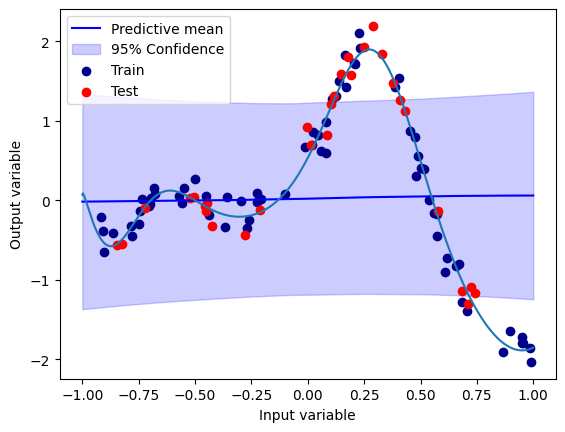

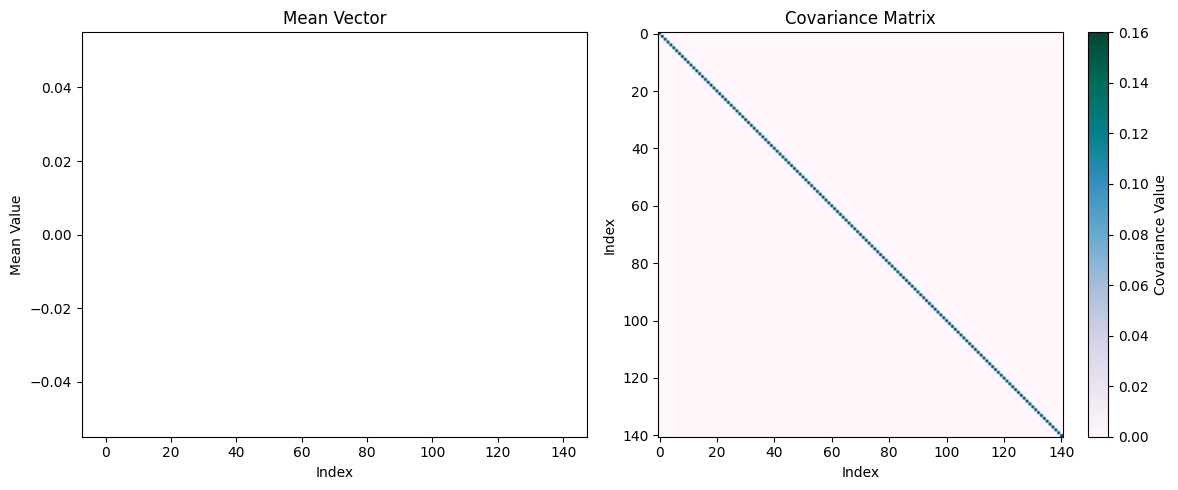

In [162]:
plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)
plot_mean_and_covariance(BNN)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


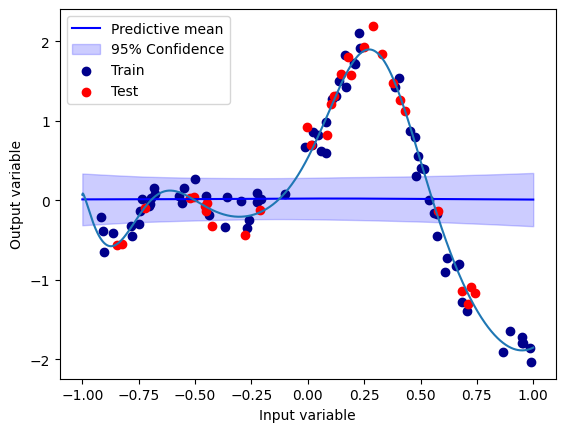

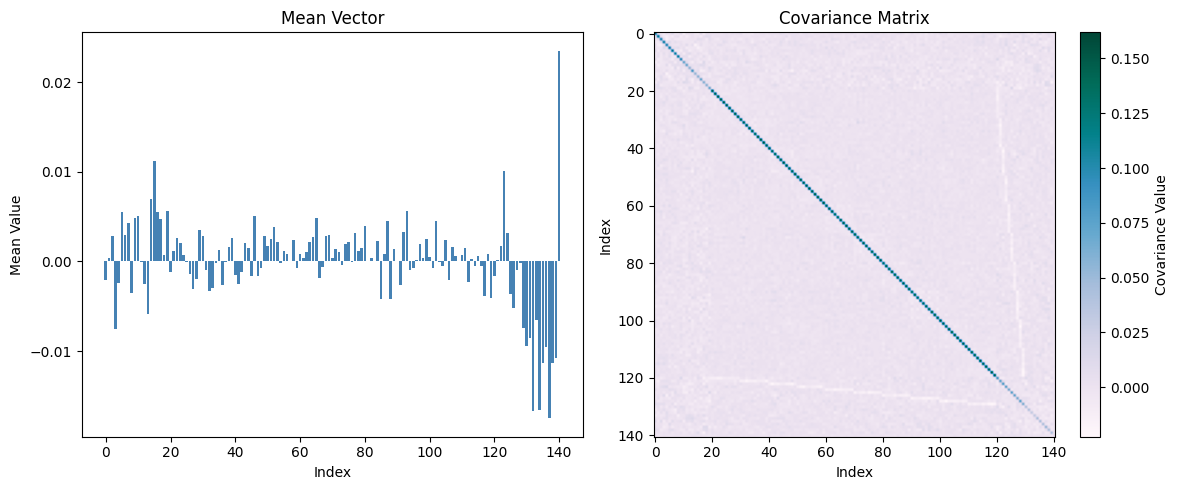

In [165]:
n_epochs = 50
noise = 0.15

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}')
    update_variational_params_testing(BNN, x_tr, y_tr, noise, K=100)

# Plot results
plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)
plot_mean_and_covariance(BNN)


In [131]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is accessible
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.current_device())  # Current GPU index
print(torch.cuda.get_device_name(0))  # Name of the GPU


False
0


AssertionError: Torch not compiled with CUDA enabled

tensor([-5.8670e-03,  1.4087e-02, -8.6050e-03, -2.6129e-03, -9.1428e-03,
         1.1611e-02, -5.9341e-03,  7.0018e-03,  6.8042e-03, -5.4094e-03,
         8.4758e-03,  9.6032e-03,  1.2083e-02,  1.5507e-03,  2.2902e-03,
         9.5799e-03, -2.0892e-03,  6.7778e-03,  3.5765e-03,  1.0203e-02,
         3.0648e-03, -1.7269e-03,  5.9227e-03,  1.4200e-03,  6.2457e-03,
         1.1771e-02,  6.2532e-03, -1.8270e-03,  2.5506e-03, -1.5542e-03,
        -7.8566e-04,  2.1298e-03,  7.3108e-04,  2.7586e-03,  1.9349e-03,
        -2.0744e-02,  1.2578e-02, -5.1646e-03,  4.6378e-03, -6.2415e-04,
        -6.2911e-03, -1.5072e-03,  2.1029e-03, -7.8232e-03, -6.2836e-03,
        -3.2493e-03,  3.2329e-03, -4.8900e-04, -1.4509e-03,  1.2013e-02,
         7.2347e-03,  1.4437e-03,  1.5256e-03, -4.0087e-03,  7.6001e-04,
         8.0752e-03,  9.0812e-03, -6.7461e-04,  3.5236e-03, -7.8250e-03,
        -3.4022e-03,  4.6155e-03,  1.8094e-03, -4.0736e-04,  5.9733e-04,
        -7.2514e-03, -7.6226e-03, -1.6673e-03, -3.9

In [158]:
sampled_params = BNN.sample_params()  # Sample from q distribution with gradient tracking

output = BNN.forward(input_data, sampled_params)  # Forward pass
print('output:',output)


output: tensor([0.0749], grad_fn=<ViewBackward0>)
